# Power System Optimization Applications

Modern power grids rely on sophisticated optimization algorithms to balance electricity supply and demand while maintaining reliability and minimizing costs. This lesson explores practical optimization techniques that grid operators use every day, from economic dispatch to handling renewable energy uncertainty.

We'll build increasingly complex models that capture real-world operational challenges. Each section includes working examples followed by exercises that deepen your understanding. The modular code structure demonstrates how these optimization patterns appear across different power system problems.

## Utility Functions

We begin by defining reusable functions for data generation, optimization setup, visualization, and results analysis. These utilities eliminate code duplication and let us focus on the unique aspects of each optimization problem.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pulp import *
import time

# Set random seed for reproducibility
np.random.seed(42)

# Configure matplotlib
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (10, 6)

In [2]:
# Data Generation Utilities

def create_generator_data(n_units=3, include_startup=False):
    """Create standard generator DataFrame."""
    data = {
        'p_min': np.linspace(20, 100, n_units),
        'p_max': np.linspace(100, 400, n_units),
        'cost': np.linspace(20, 35, n_units)
    }
    
    if include_startup:
        # Fixed arrays to ensure proper length for any n_units
        min_up_values = [2, 4, 8, 2, 4][:n_units]
        min_down_values = [2, 4, 8, 2, 4][:n_units]
        initial_status_values = [1, 1, 0, 0, 0][:n_units]
        initial_power_values = [data['p_min'][i] if initial_status_values[i] else 0 
                                for i in range(n_units)]
        
        data.update({
            'startup_cost': np.linspace(1000, 5000, n_units),
            'min_up': np.array(min_up_values),
            'min_down': np.array(min_down_values),
            'ramp_up': data['p_max'] * 0.2,
            'ramp_down': data['p_max'] * 0.2,
            'initial_status': initial_status_values,
            'initial_power': initial_power_values
        })
    
    return pd.DataFrame(data, index=[f'G{i+1}' for i in range(n_units)])

def create_demand_profile(hours=24, base=300, peak_hour=16):
    """Generate realistic daily demand profile."""
    t = np.arange(hours)
    demand = base + 100 * np.sin((t - 6) * np.pi / 12)
    demand = np.maximum(demand, 0.7 * base)
    return demand

def create_simple_network():
    """Create 3-bus test network."""
    buses = pd.DataFrame({'demand': [0, 100, 80]}, 
                        index=['Bus1', 'Bus2', 'Bus3'])
    
    # Increased generator capacities to ensure feasibility
    generators = pd.DataFrame({
        'bus': ['Bus1', 'Bus1', 'Bus3'],
        'p_max': [200, 150, 150],  # Increased from [150, 100, 120]
        'cost': [20, 25, 22]
    }, index=['G1', 'G2', 'G3'])
    
    lines = pd.DataFrame({
        'from_bus': ['Bus1', 'Bus1', 'Bus2'],
        'to_bus': ['Bus2', 'Bus3', 'Bus3'],
        'limit': [120, 100, 80],
        'reactance': [0.1, 0.15, 0.2]
    }, index=['L1', 'L2', 'L3'])
    
    return buses, generators, lines

def calculate_ptdf(buses, lines):
    """Return PTDF matrix."""
    ptdf = np.array([
        [0.1667, -0.5000, 0],    # Line 0-1
        [0.1667,  0.5000, 0],    # Line 1-2
        [0.8333,  0.5000, 0]     # Line 0-2
    ])
    
    return ptdf

In [3]:
# Optimization Utilities

def add_power_balance(prob, p_vars, demand, name="Power_Balance"):
    """Add power balance constraint to optimization problem."""
    prob += lpSum(p_vars.values()) == demand, name
    return prob

def add_generator_limits(prob, p_vars, generators, u_vars=None):
    """Add generation limit constraints."""
    for g in generators.index:
        if u_vars:
            prob += p_vars[g] >= generators.loc[g, 'p_min'] * u_vars[g]
            prob += p_vars[g] <= generators.loc[g, 'p_max'] * u_vars[g]
        else:
            prob += p_vars[g] >= generators.loc[g, 'p_min']
            prob += p_vars[g] <= generators.loc[g, 'p_max']
    return prob

def solve_and_extract_results(prob, p_vars):
    """Solve optimization and extract generation results."""
    prob.solve(PULP_CBC_CMD(msg=0))
    
    results = {
        'status': LpStatus[prob.status],
        'cost': value(prob.objective),
        'generation': {g: value(p) for g, p in p_vars.items()}
    }
    
    # Extract LMP if power balance constraint exists
    # Check for both naming conventions for compatibility
    if 'Power_Balance' in prob.constraints:
        results['lmp'] = prob.constraints['Power_Balance'].pi
    elif 'PowerBalance' in prob.constraints:
        results['lmp'] = prob.constraints['PowerBalance'].pi
    
    return results

In [4]:
# Visualization Utilities

def plot_generation_dispatch(results, generators, demand=None, title="Generation Dispatch"):
    """Create bar chart of generation dispatch."""
    fig, ax = plt.subplots(figsize=(10, 6))
    
    gen_values = list(results['generation'].values())
    gen_names = list(results['generation'].keys())
    
    bars = ax.bar(gen_names, gen_values, color='skyblue', edgecolor='navy')
    
    # Add value labels on bars
    for bar, val in zip(bars, gen_values):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 2,
                f'{val:.1f} MW', ha='center', va='bottom')
    
    if demand:
        ax.axhline(y=demand, color='red', linestyle='--', label=f'Demand: {demand} MW')
    
    ax.set_xlabel('Generator')
    ax.set_ylabel('Power Output (MW)')
    ax.set_title(title)
    ax.grid(True, alpha=0.3)
    if demand:
        ax.legend()
    
    return fig, ax

def plot_demand_profile(demand, title="24-Hour Demand Profile"):
    """Plot hourly demand profile."""
    fig, ax = plt.subplots(figsize=(12, 5))
    
    hours = range(len(demand))
    ax.bar(hours, demand, color='skyblue', edgecolor='navy', alpha=0.7)
    ax.plot(hours, demand, 'r-', linewidth=2)
    
    ax.set_xlabel('Hour')
    ax.set_ylabel('Demand (MW)')
    ax.set_title(title)
    ax.grid(True, alpha=0.3)
    
    return fig, ax

def plot_unit_commitment_schedule(schedule_df, generation_df, demand):
    """Visualize unit commitment schedule and generation stack."""
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))
    
    # Convert DataFrames to ensure numeric types
    generation_numeric = generation_df.astype(float)
    schedule_numeric = schedule_df.astype(int)
    
    # Generation stack
    bottom = np.zeros(len(demand))
    colors = plt.cm.Set3(np.linspace(0, 1, len(generation_numeric)))
    
    for i, (gen, row) in enumerate(generation_numeric.iterrows()):
        # Ensure row values are numpy array of floats
        gen_values = row.values.astype(float)
        ax1.bar(range(len(demand)), gen_values, bottom=bottom,
                label=gen, color=colors[i], edgecolor='black', linewidth=0.5)
        bottom += gen_values
    
    ax1.plot(range(len(demand)), demand, 'k--', linewidth=2, label='Demand')
    ax1.set_xlabel('Hour')
    ax1.set_ylabel('Power (MW)')
    ax1.set_title('Generation Schedule')
    ax1.legend(loc='upper right')
    ax1.grid(True, alpha=0.3)

    im = ax2.pcolormesh(np.arange(len(demand)+1), np.arange(len(schedule)+1),
                      schedule_numeric, cmap='RdYlGn', edgecolors='black', linewidth=1)
    ax2.set_yticks(np.arange(len(schedule)) + 0.5)
    ax2.set_yticklabels(schedule.index)
    ax2.set_xticks(np.arange(len(demand)) + 0.5)
    ax2.set_xticklabels(range(len(demand)))
    ax2.set_xlabel('Hour')
    ax2.set_title('Unit On/Off Status (Green=On, Red=Off)')
    ax2.invert_yaxis()  # Flip to match imshow orientation
    
    # Add text annotations
    for i in range(len(schedule)):
        for j in range(len(demand)):
            text = ax2.text(j + 0.5, i + 0.5, int(schedule_numeric.values[i, j]),
                            ha="center", va="center", color="black", fontweight='bold')

    return fig, (ax1, ax2)

In [5]:
# Results Analysis Utilities

def print_optimization_results(results, title="Optimization Results"):
    """Print formatted optimization results."""
    print(f"\n{title}")
    print("=" * len(title))
    print(f"Status: {results['status']}")
    print(f"Total cost: ${results['cost']:.2f}")
    
    if 'lmp' in results:
        print(f"LMP: ${results['lmp']:.2f}/MWh")
    
    print("\nGeneration dispatch:")
    for gen, power in results['generation'].items():
        print(f"  {gen}: {power:.1f} MW")

def calculate_line_flows(buses, lines, p_injection):
    """Calculate DC power flows on lines."""
    flows = {}
    
    for _, line in lines.iterrows():
        theta_from = p_injection.get(line['from_bus'], 0)
        theta_to = p_injection.get(line['to_bus'], 0)
        flows[line.name] = (theta_from - theta_to) / line['reactance']
    
    return flows

## 1. Introduction to Power System Optimization

Power system optimization determines how to operate the grid most efficiently while maintaining reliability. At its core, this means deciding which generators to run and at what output levels. Let's start with a simple example that demonstrates the fundamental concepts.

Generator Data:
    p_min  p_max  cost
G1   20.0  100.0  20.0
G2   60.0  250.0  27.5
G3  100.0  400.0  35.0

Simple Economic Dispatch
Status: Optimal
Total cost: $6950.00
LMP: $20.00/MWh

Generation dispatch:
  G1: 90.0 MW
  G2: 60.0 MW
  G3: 100.0 MW


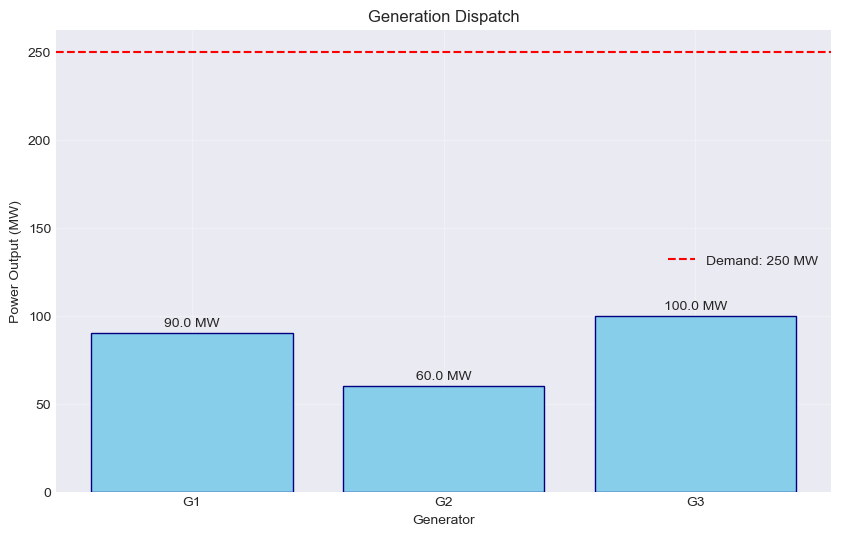

In [6]:
# Simple Economic Dispatch Example
generators = create_generator_data(n_units=3)
demand = 250  # MW

print("Generator Data:")
print(generators)

# Create and solve ED problem
prob = LpProblem("Simple_ED", LpMinimize)

# Decision variables
p = {g: LpVariable(f"p_{g}", 0) for g in generators.index}

# Objective: minimize cost
prob += lpSum(generators.loc[g, 'cost'] * p[g] for g in generators.index)

# Constraints
add_power_balance(prob, p, demand)
add_generator_limits(prob, p, generators)

# Solve and display results
results = solve_and_extract_results(prob, p)
print_optimization_results(results, "Simple Economic Dispatch")
plot_generation_dispatch(results, generators, demand);

## 2. Advanced Economic Dispatch

Real generators have more complex cost characteristics than simple linear functions. Piecewise linear costs better represent efficiency variations across the operating range, while prohibited zones capture mechanical limitations that prevent operation at certain power levels.

### Example: Piecewise Linear Costs

Many generators become less efficient at higher output levels, leading to increasing marginal costs. We model this with piecewise linear segments where each segment has a different cost slope.

When generators operate at discontinuity points between segments, the marginal cost becomes undefined, creating challenges for market pricing. The example below demonstrates how one generator operating within a segment provides a clear marginal price signal while another at a discontinuity point has an undefined marginal cost.

In [7]:
def solve_piecewise_ed(demand=265):
    """Economic dispatch with piecewise linear costs."""
    # Define generators with cost segments
    piecewise_data = {
        'G1': {
            'segments': [(50, 100, 20), (100, 150, 22), (150, 200, 25)],  # (start, end, cost)
        },
        'G2': {
            'segments': [(40, 100, 24), (100, 150, 28)],
        }
      }
    
    prob = LpProblem("Piecewise_ED", LpMinimize)
    
    # Variables for each segment
    p_seg = {}
    for g, data in piecewise_data.items():
        for i, (start, end, cost) in enumerate(data['segments']):
            p_seg[g, i] = LpVariable(f"p_{g}_{i}", 0, end - start)
    
    # Binary variables to indicate if a segment is used
    z_seg = {}
    for g, data in piecewise_data.items():
        for i in range(len(data['segments'])):
            z_seg[g, i] = LpVariable(f"z_{g}_{i}", cat='Binary')
    
    # Total generation per unit (actual power output)
    p_total = {}
    for g in piecewise_data:
        # Actual generation = minimum + sum of segment increments
        min_gen = piecewise_data[g]['segments'][0][0]
        p_total[g] = min_gen + lpSum(p_seg[g, i]
                                   for i in range(len(piecewise_data[g]['segments'])))
    
    # Objective
    prob += lpSum(
        piecewise_data[g]['segments'][i][2] * p_seg[g, i]
        for g in piecewise_data
        for i in range(len(piecewise_data[g]['segments']))
    )
    
    # Constraints
    prob += lpSum(p_total[g] for g in piecewise_data) == demand, "Power_Balance"

    # Enforce piecewise structure: segments must be filled in order
    for g in piecewise_data:
        # First segment can always be used
        if len(piecewise_data[g]['segments']) > 0:
            start, end, _ = piecewise_data[g]['segments'][0]
            prob += p_seg[g, 0] <= (end - start) * z_seg[g, 0]
    
        # Subsequent segments
        for i in range(1, len(piecewise_data[g]['segments'])):
            start, end, _ = piecewise_data[g]['segments'][i]
            start_prev, end_prev, _ = piecewise_data[g]['segments'][i-1]
    
            # Segment i can only be used if segment i-1 is full
            prob += z_seg[g, i] <= z_seg[g, i-1]
            prob += p_seg[g, i] <= (end - start) * z_seg[g, i]
            prob += p_seg[g, i-1] >= (end_prev - start_prev) * z_seg[g, i] - 0.001
    
    prob.solve(PULP_CBC_CMD(msg=0))
    
    # Extract results
    results = {
      'status': LpStatus[prob.status],
      'cost': value(prob.objective),
      'generation': {g: value(p_total[g]) for g in piecewise_data},
      'lmp': prob.constraints['Power_Balance'].pi
    }
    
    return results

In [8]:
# Solve and visualize
results = solve_piecewise_ed(265)
print_optimization_results(results, "Piecewise Linear Economic Dispatch")


Piecewise Linear Economic Dispatch
Status: Optimal
Total cost: $3915.00
LMP: $25.00/MWh

Generation dispatch:
  G1: 165.0 MW
  G2: 100.0 MW


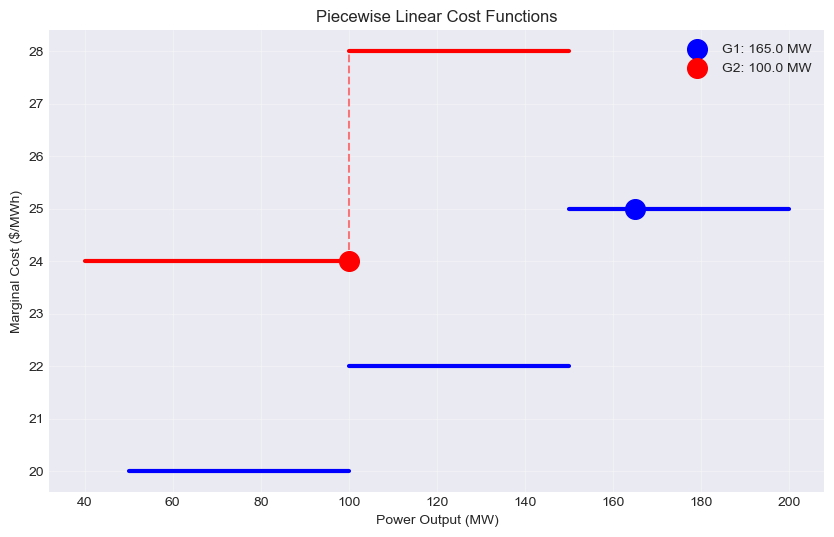

In [9]:

# Show cost curves
fig, ax = plt.subplots(figsize=(10, 6))
colors = ['blue', 'red']
for i, (g, color) in enumerate(zip(['G1', 'G2'], colors)):
    if g == 'G1':
        segments = [(50, 100, 20), (100, 150, 22), (150, 200, 25)]
    else:
        segments = [(40, 100, 24), (100, 150, 28)]
    
    # Plot the segments
    for start, end, cost in segments:
        ax.plot([start, end], [cost, cost], color=color, linewidth=3)
    
    # Mark dispatch point with correct marginal cost
    dispatch = results['generation'][g]
    
    # Find which segment the generator is operating in
    marginal_cost = None
    at_discontinuity = False
            
    
    for idx, (start, end, cost) in enumerate(segments):
        if start <= dispatch <= end:
            # Always use the cost of the current segment
            marginal_cost = cost
            
            # If at a discontinuity, still show the vertical line
            if dispatch == end and idx < len(segments) - 1:
                # At end of segment (discontinuity with next)
                next_cost = segments[idx + 1][2]
                ax.vlines(dispatch, cost, next_cost, colors=color, linestyles='dashed', alpha=0.5)
            elif dispatch == start and idx > 0:
                # At start of segment (discontinuity with previous)
                prev_cost = segments[idx - 1][2]
                ax.vlines(dispatch, prev_cost, cost, colors=color, linestyles='dashed', alpha=0.5)
            
            break
    
    # Plot dispatch point at correct cost
    y_pos = marginal_cost
    ax.scatter(dispatch, y_pos, s=200, color=color, zorder=3, 
               label=f'{g}: {dispatch:.1f} MW')
    
ax.set_xlabel('Power Output (MW)')
ax.set_ylabel('Marginal Cost ($/MWh)')
ax.set_title('Piecewise Linear Cost Functions')
ax.legend()
ax.grid(True, alpha=0.3)
plt.show()

### Exercise 2.1: Economic Dispatch with Prohibited Zones

Some generators cannot operate in certain power ranges due to mechanical vibrations or other technical constraints. These prohibited operating zones create a more complex optimization problem that requires binary variables to ensure feasible solutions.

Implement economic dispatch for three generators where G1 cannot operate between 75-85 MW and G2 cannot operate between 110-120 MW. The total system demand is 300 MW. Your solution should use binary variables to select which operating zone each generator uses, ensuring no generator operates in its prohibited range.

**Hint:** For each generator with prohibited zones, create separate continuous variables for each allowable operating range. Use binary variables to ensure only one range is active. The sum of all zone outputs equals the generator's total output.

In [10]:
# Exercise 2.1: Your implementation here
def ed_with_prohibited_zones(demand=300):
    # Define generator data
    generators = {
        'G1': {'p_min': 50, 'p_max': 150, 'cost': 22, 'prohibited': [(75, 85)]},
        'G2': {'p_min': 40, 'p_max': 180, 'cost': 25, 'prohibited': [(110, 120)]},
        'G3': {'p_min': 30, 'p_max': 120, 'cost': 30, 'prohibited': []}
    }
    
    # Your solution here
    pass


Economic Dispatch with Prohibited Zones:
Status: Optimal
Total cost: $7200.00
LMP: $22.00/MWh

G1: 150.0 MW
G2: 120.0 MW
G3: 30.0 MW

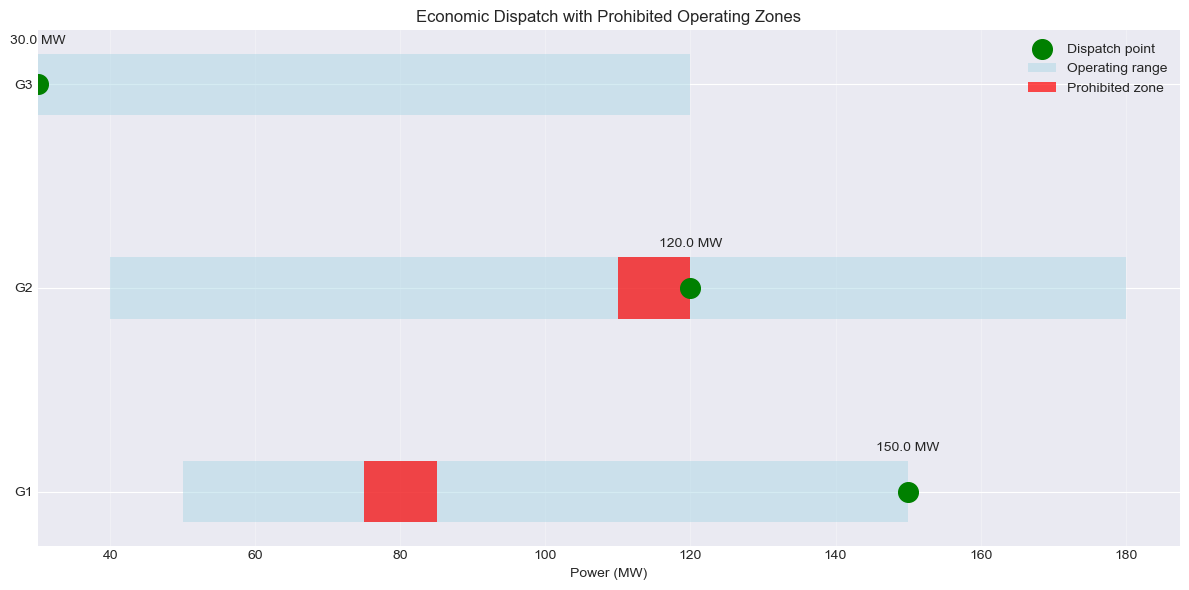

In [11]:
# Solution for Exercise 2.1: Economic Dispatch with Prohibited Zones
def ed_with_prohibited_zones(demand=300):
    """Solve ED with prohibited operating zones using binary variables."""
    prob = LpProblem("ED_Prohibited_Zones", LpMinimize)
    
    # Generator data
    generators = {
        'G1': {'p_min': 50, 'p_max': 150, 'cost': 22, 'prohibited': [(75, 85)]},
        'G2': {'p_min': 40, 'p_max': 180, 'cost': 25, 'prohibited': [(110, 120)]},
        'G3': {'p_min': 30, 'p_max': 120, 'cost': 30, 'prohibited': []}
    }
    
    # Decision variables for each operating zone
    p_zones = {}
    z_zones = {}  # Binary variables for zone selection
    
    for g_id, gen in generators.items():
        if not gen['prohibited']:
            # No prohibited zones - single operating range
            p_zones[g_id, 0] = LpVariable(f"p_{g_id}_0", gen['p_min'], gen['p_max'])
        else:
            # Create zones around prohibited regions
            zones = []
            start = gen['p_min']
            
            for prohib_start, prohib_end in gen['prohibited']:
                if prohib_start > start:
                    zones.append((start, prohib_start))
                start = prohib_end
            
            if start < gen['p_max']:
                zones.append((start, gen['p_max']))
            
            # Create variables for each zone
            for i, (z_min, z_max) in enumerate(zones):
                p_zones[g_id, i] = LpVariable(f"p_{g_id}_{i}", 0)
                z_zones[g_id, i] = LpVariable(f"z_{g_id}_{i}", cat='Binary')
                
                # Zone constraints
                prob += p_zones[g_id, i] >= z_min * z_zones[g_id, i]
                prob += p_zones[g_id, i] <= z_max * z_zones[g_id, i]
            
            # Only one zone can be active
            prob += lpSum(z_zones[g_id, i] for i in range(len(zones))) == 1
    
    # Total generation per unit
    p_total = {}
    for g_id in generators:
        if not generators[g_id]['prohibited']:
            p_total[g_id] = p_zones[g_id, 0]
        else:
            n_zones = len([k for k in p_zones if k[0] == g_id])
            p_total[g_id] = lpSum(p_zones[g_id, i] for i in range(n_zones))
    
    # Objective: minimize total cost
    prob += lpSum(generators[g_id]['cost'] * p_total[g_id] for g_id in generators)
    
    # Demand constraint
    prob += lpSum(p_total[g_id] for g_id in generators) == demand, "Demand"
    
    # Solve
    prob.solve(PULP_CBC_CMD(msg=0))
    
    # Display results
    print("\nEconomic Dispatch with Prohibited Zones:")
    print(f"Status: {LpStatus[prob.status]}")
    print(f"Total cost: ${value(prob.objective):.2f}")
    print(f"LMP: ${prob.constraints['Demand'].pi:.2f}/MWh")
    
    for g_id in generators:
        gen_output = value(p_total[g_id])
        print(f"\n{g_id}: {gen_output:.1f} MW", end="")
        
        # Check if in prohibited zone (should never happen)
        for p_start, p_end in generators[g_id]['prohibited']:
            if p_start < gen_output < p_end:
                print(" (ERROR: In prohibited zone!)", end="")
    
    # Visualize the solution
    fig, ax = plt.subplots(figsize=(12, 6))
    
    for i, (g_id, gen) in enumerate(generators.items()):
        y_pos = i
        
        # Operating range
        ax.barh(y_pos, gen['p_max'] - gen['p_min'], left=gen['p_min'], 
                height=0.3, color='lightblue', alpha=0.5, label='Operating range' if i==0 else '')
        
        # Prohibited zones
        for p_start, p_end in gen['prohibited']:
            ax.barh(y_pos, p_end - p_start, left=p_start, 
                    height=0.3, color='red', alpha=0.7, label='Prohibited zone' if i==0 else '')
        
        # Actual generation
        gen_value = value(p_total[g_id])
        ax.scatter(gen_value, y_pos, s=200, color='green', zorder=3, 
                   label='Dispatch point' if i==0 else '')
        ax.text(gen_value, y_pos + 0.2, f'{gen_value:.1f} MW', ha='center')
    
    ax.set_yticks(range(3))
    ax.set_yticklabels(['G1', 'G2', 'G3'])
    ax.set_xlabel('Power (MW)')
    ax.set_title('Economic Dispatch with Prohibited Operating Zones')
    ax.legend()
    ax.grid(True, axis='x', alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    return prob, p_total

# Run the solution
prob, p_total = ed_with_prohibited_zones(300)

## 3. Unit Commitment

Unit commitment extends economic dispatch by determining not just how much each generator produces, but also when to start up or shut down units. This mixed-integer optimization problem balances operating costs against startup costs while respecting technical constraints like minimum run times.

Let's start with a simplified example before tackling the full formulation.

### Example: Simple Unit Commitment

We'll solve unit commitment for a small system over 6 hours, focusing on the core concepts of binary commitment decisions and startup costs.

In [12]:
def simple_unit_commitment():
    """Simplified UC for 3 units over 8 hours with clear on/off behavior."""
    # Create more distinctive generator characteristics
    generators = pd.DataFrame({
        'p_min': [100, 30, 20],      # G1 has high minimum (base load)
        'p_max': [200, 150, 80],     # Different capacities
        'cost': [10, 25, 50],        # Significant cost differences
        'startup_cost': [500, 2000, 1000],  # G2 has high startup cost
        'initial_status': [1, 0, 0],  # Only G1 starts on
        'initial_power': [150, 0, 0]
    }, index=['G1_Base', 'G2_Mid', 'G3_Peak'])
    
    hours = 8
    # Create demand profile that forces unit cycling
    demand = np.array([120, 130, 180, 250, 360, 350, 200, 140])
    
    # Display data
    print("Generator Data:")
    print(generators[['p_min', 'p_max', 'cost', 'startup_cost']])
    print(f"\nDemand: {demand}")
    
    # Create problem
    prob = LpProblem("Simple_UC", LpMinimize)
    periods = range(hours)
    
    # Variables
    u = {}  # Unit on/off
    p = {}  # Power output
    v = {}  # Startup indicator
    
    for g in generators.index:
        for t in periods:
            u[g,t] = LpVariable(f"u_{g}_{t}", cat='Binary')
            p[g,t] = LpVariable(f"p_{g}_{t}", 0)
            v[g,t] = LpVariable(f"v_{g}_{t}", cat='Binary')
    
    # Objective
    operating_cost = lpSum(generators.loc[g, 'cost'] * p[g,t] 
                          for g in generators.index for t in periods)
    startup_cost = lpSum(generators.loc[g, 'startup_cost'] * v[g,t]
                        for g in generators.index for t in periods)
    prob += operating_cost + startup_cost
    
    # Constraints
    for t in periods:
        # Power balance
        prob += lpSum(p[g,t] for g in generators.index) == demand[t]
        
        # Reserve (simplified - 5% of demand)
        prob += lpSum(generators.loc[g, 'p_max'] * u[g,t] 
                     for g in generators.index) >= 1.05 * demand[t]
    
    for g in generators.index:
        for t in periods:
            # Generation limits
            prob += p[g,t] >= generators.loc[g, 'p_min'] * u[g,t]
            prob += p[g,t] <= generators.loc[g, 'p_max'] * u[g,t]
            
            # Startup logic
            if t == 0:
                prob += v[g,t] >= u[g,t] - generators.loc[g, 'initial_status']
            else:
                prob += v[g,t] >= u[g,t] - u[g,t-1]
    
    # Solve
    prob.solve(PULP_CBC_CMD(msg=0))
    
    # Extract results
    schedule = pd.DataFrame(index=generators.index, columns=periods)
    generation = pd.DataFrame(index=generators.index, columns=periods)
    
    for g in generators.index:
        for t in periods:
            schedule.loc[g, t] = int(value(u[g,t]))
            generation.loc[g, t] = value(p[g,t]) if schedule.loc[g, t] else 0
    
    return schedule, generation, demand, value(prob.objective)


In [13]:
# Solve and visualize
schedule, generation, demand, total_cost = simple_unit_commitment()

print(f"\nTotal cost: ${total_cost:,.0f}")
print("\nUnit Schedule (1=ON, 0=OFF):")
print(schedule)
print("\nStartup events:")
for g in generation.index:
    startups = []
    for t in range(len(demand)):
        if t == 0 and schedule.loc[g, 0] == 1 and g != 'G1_Base':  # G1 was already on
            startups.append(0)
        elif t > 0 and schedule.loc[g, t] == 1 and schedule.loc[g, t-1] == 0:
            startups.append(t)
    if startups:
        print(f"{g}: hours {startups}")

print("\nShutdown events:")
for g in generation.index:
    shutdowns = []
    for t in range(len(demand)):
        if t > 0 and schedule.loc[g, t] == 0 and schedule.loc[g, t-1] == 1:
            shutdowns.append(t)
    if shutdowns:
        print(f"{g}: hours {shutdowns}")

Generator Data:
         p_min  p_max  cost  startup_cost
G1_Base    100    200    10           500
G2_Mid      30    150    25          2000
G3_Peak     20     80    50          1000

Demand: [120 130 180 250 360 350 200 140]

Total cost: $27,150

Unit Schedule (1=ON, 0=OFF):
         0  1  2  3  4  5  6  7
G1_Base  1  1  1  1  1  1  1  1
G2_Mid   0  0  0  1  1  1  1  0
G3_Peak  0  0  0  0  1  1  0  0

Startup events:
G2_Mid: hours [3]
G3_Peak: hours [4]

Shutdown events:
G2_Mid: hours [7]
G3_Peak: hours [6]


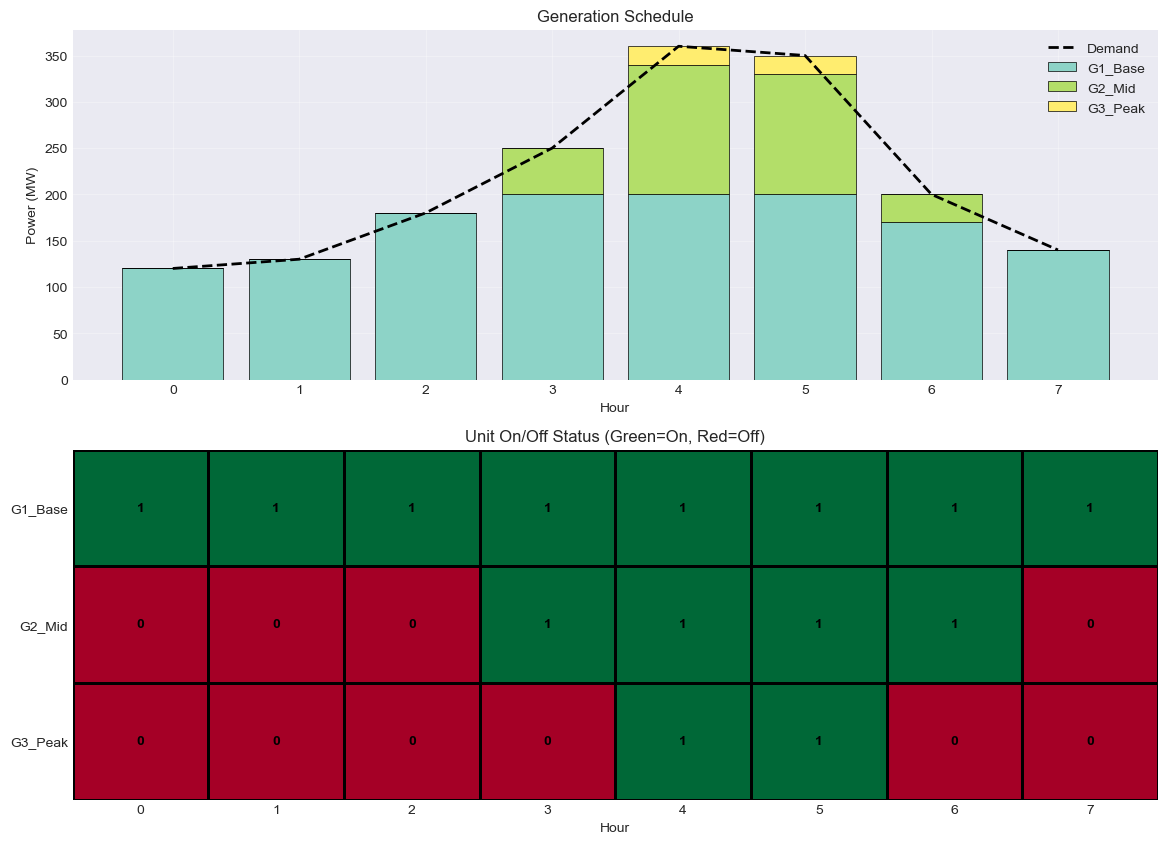

In [14]:
fig, ax = plot_unit_commitment_schedule(schedule, generation, demand)

### Exercise 3.1: Full Unit Commitment with Technical Constraints

Real unit commitment problems include additional technical constraints that ensure feasible generator operation. Minimum up and down times prevent excessive cycling that would damage equipment, while ramping limits restrict how quickly generators can change output.

Extend the simple unit commitment to include minimum up/down time constraints and ramping limits for a 24-hour period. Use the provided generator data which includes these technical parameters. Your formulation should ensure that once a unit starts up, it remains on for at least its minimum up time, and similarly for shutdowns.

**Hint:** For minimum up time of 4 hours, if a unit starts at hour t, it must remain on through hour t+3. Use the startup variable v[g,t] to trigger these constraints. Ramping constraints limit the change in output between consecutive hours but must account for startup and shutdown transitions.

In [20]:
# Exercise 3.1: Your implementation here
def full_unit_commitment():
    # Load data
    tot_hours = 24
    generators = create_generator_data(n_units=3, include_startup=True)
    demand = create_demand_profile(hours=tot_hours)
    
    # Display the data
    plot_demand_profile(demand)
    plt.show()
    
    print("Generator Data:")
    print(generators)
    
    # Your implementation here
    pass

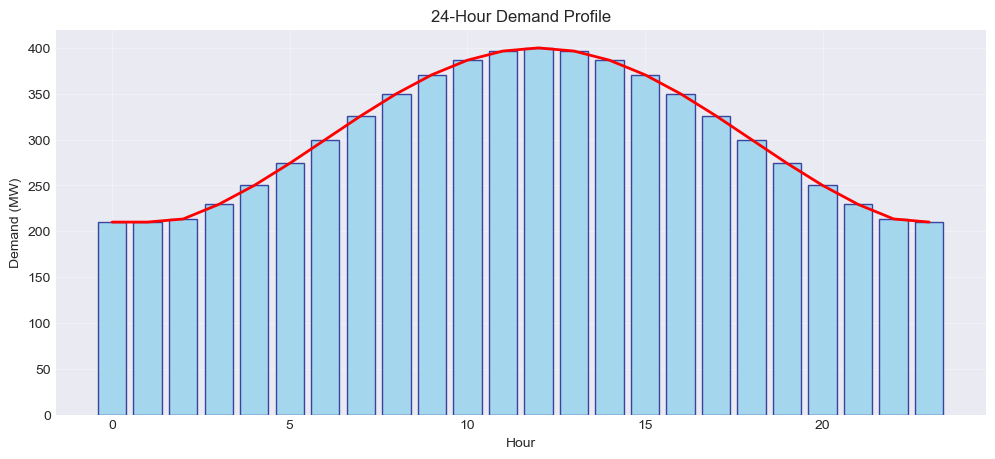

Generator Data:
    p_min  p_max  cost  startup_cost  min_up  min_down  ramp_up  ramp_down  \
G1   20.0  100.0  20.0        1000.0       2         2     20.0       20.0   
G2   60.0  250.0  27.5        3000.0       4         4     50.0       50.0   
G3  100.0  400.0  35.0        5000.0       8         8     80.0       80.0   

    initial_status  initial_power  
G1               1           20.0  
G2               1           60.0  
G3               0            0.0  

Unit Commitment Results:
Status: Optimal
Total cost: $202,877
Solve time: 0.43 seconds


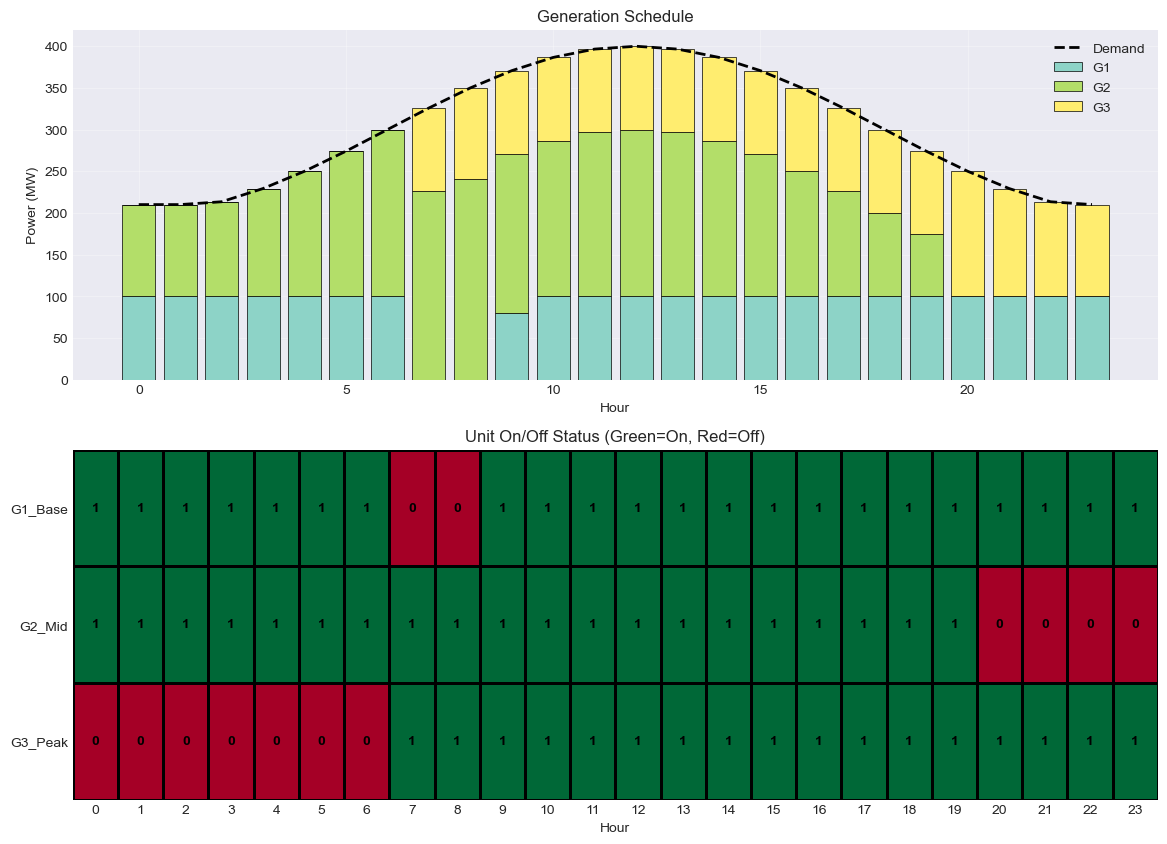


Cost Breakdown:
Operating cost: $195,877
Startup cost: $7,000

Startup events:
G1: hours [0, 9]
G3: hours [7]


In [19]:
# Solution for Exercise 3.1: Full Unit Commitment with Technical Constraints
def full_unit_commitment():
    """Complete UC formulation with all technical constraints."""
    # Load data
    tot_hours = 24
    generators = create_generator_data(n_units=3, include_startup=True)
    demand = create_demand_profile(hours=tot_hours)
    T = len(demand)
    periods = range(T)
    gen_names = generators.index.tolist()
    
    # Display the data
    plot_demand_profile(demand)
    plt.show()
    
    print("Generator Data:")
    print(generators)
    
    # Create problem
    prob = LpProblem("Full_Unit_Commitment", LpMinimize)
    
    # Decision variables
    u = {}  # Unit on/off
    p = {}  # Power output
    v = {}  # Startup indicator
    w = {}  # Shutdown indicator
    
    for g in gen_names:
        for t in periods:
            u[g,t] = LpVariable(f"u_{g}_{t}", cat='Binary')
            p[g,t] = LpVariable(f"p_{g}_{t}", 0)
            v[g,t] = LpVariable(f"v_{g}_{t}", cat='Binary')
            w[g,t] = LpVariable(f"w_{g}_{t}", cat='Binary')
    
    # Objective: minimize total cost
    prob += lpSum(
        generators.loc[g, 'cost'] * p[g,t] + 
        generators.loc[g, 'startup_cost'] * v[g,t]
        for g in gen_names for t in periods
    )
    
    # Constraints
    for t in periods:
        # Demand constraint
        prob += lpSum(p[g,t] for g in gen_names) == demand[t], f"Demand_{t}"
        
        # Reserve constraint (10% of demand)
        prob += lpSum(
            generators.loc[g, 'p_max'] * u[g,t] - p[g,t] 
            for g in gen_names
        ) >= 0.1 * demand[t], f"Reserve_{t}"
    
    for g in gen_names:
        for t in periods:
            # Generation limits
            prob += p[g,t] >= generators.loc[g, 'p_min'] * u[g,t], f"P_min_{g}_{t}"
            prob += p[g,t] <= generators.loc[g, 'p_max'] * u[g,t], f"P_max_{g}_{t}"
            
            # Startup/shutdown logic
            if t == 0:
                # Initial conditions
                initial_u = generators.loc[g, 'initial_status']
                prob += v[g,t] >= u[g,t] - initial_u, f"Startup_{g}_{t}"
                prob += w[g,t] >= initial_u - u[g,t], f"Shutdown_{g}_{t}"
            else:
                prob += v[g,t] >= u[g,t] - u[g,t-1], f"Startup_{g}_{t}"
                prob += w[g,t] >= u[g,t-1] - u[g,t], f"Shutdown_{g}_{t}"
            
            # Ramping constraints
            if t > 0:
                # Ramp up
                prob += (p[g,t] - p[g,t-1] <= 
                        generators.loc[g, 'ramp_up'] * u[g,t-1] + 
                        generators.loc[g, 'p_max'] * v[g,t]), f"RampUp_{g}_{t}"
                # Ramp down
                prob += (p[g,t-1] - p[g,t] <= 
                        generators.loc[g, 'ramp_down'] * u[g,t] + 
                        generators.loc[g, 'p_max'] * w[g,t]), f"RampDown_{g}_{t}"
            else:
                # Initial ramping from initial power
                initial_p = generators.loc[g, 'initial_power']
                initial_u = generators.loc[g, 'initial_status']
                prob += (p[g,t] - initial_p <= 
                        generators.loc[g, 'ramp_up'] * initial_u + 
                        generators.loc[g, 'p_max'] * v[g,t]), f"RampUp_{g}_{t}"
    
    # Minimum up/down time constraints
    for g in gen_names:
        min_up = int(generators.loc[g, 'min_up'])
        min_down = int(generators.loc[g, 'min_down'])
        
        # Minimum up time
        for t in periods:
            t_end = min(t + min_up, T)
            if t_end > t:
                prob += (lpSum(u[g,k] for k in range(t, t_end)) >= 
                        min_up * v[g,t]), f"MinUp_{g}_{t}"
        
        # Minimum down time
        for t in periods:
            t_end = min(t + min_down, T)
            if t_end > t:
                prob += (lpSum(1 - u[g,k] for k in range(t, t_end)) >= 
                        min_down * w[g,t]), f"MinDown_{g}_{t}"
    
    # Solve
    start_time = time.time()
    prob.solve(PULP_CBC_CMD(timeLimit=60, msg=0))
    solve_time = time.time() - start_time
    
    print(f"\nUnit Commitment Results:")
    print(f"Status: {LpStatus[prob.status]}")
    print(f"Total cost: ${value(prob.objective):,.0f}")
    print(f"Solve time: {solve_time:.2f} seconds")
    
    # Create commitment schedule - ensure numeric types
    schedule = pd.DataFrame(index=generators.index, columns=list(range(tot_hours)))
    generation = pd.DataFrame(index=generators.index, columns=list(range(tot_hours)))
    
    for g in generators.index:
        for t in range(tot_hours):
            u_val = value(u[g,t])
            p_val = value(p[g,t])
            
            # Ensure we have numeric values
            schedule.loc[g, t] = 1 if u_val > 0.5 else 0
            generation.loc[g, t] = p_val if u_val > 0.5 else 0.0
    
    # Visualize results
    fig = plot_unit_commitment_schedule(schedule, generation, demand)
    plt.show()
    
    # Summary statistics
    total_startup_cost = sum(generators.loc[g, 'startup_cost'] * value(v[g,t]) 
                             for g in generators.index for t in range(tot_hours))
    total_operating_cost = value(prob.objective) - total_startup_cost
    
    print(f"\nCost Breakdown:")
    print(f"Operating cost: ${total_operating_cost:,.0f}")
    print(f"Startup cost: ${total_startup_cost:,.0f}")
    print(f"\nStartup events:")
    for g in generators.index:
        startups = [t for t in range(tot_hours) if value(v[g,t]) > 0.5]
        if startups:
            print(f"{g}: hours {startups}")
    
    return prob, u, p, v, w

# Run the solution
prob, u, p, v, w = full_unit_commitment()

## 4. Security-Constrained Optimization

Power systems must maintain reliability even when equipment fails. Security-constrained optimization ensures the system can withstand contingencies without violating operational limits. We'll explore how to incorporate N-1 security criteria into economic dispatch.

### Example: Security-Constrained Economic Dispatch

This example demonstrates SCED on a 3-bus system where we ensure all transmission lines remain within limits both during normal operation and after any single line outage.

Network Data:

Generators:
     bus  p_max  cost
G1  Bus1    200    20
G2  Bus1    150    25
G3  Bus3    150    22

Transmission Lines:
   from_bus to_bus  limit
L1     Bus1   Bus2    120
L2     Bus1   Bus3    100
L3     Bus2   Bus3     80
Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/hacui/mambaforge/envs/pct/lib/python3.11/site-packages/pulp/apis/../solverdir/cbc/linux/i64/cbc /tmp/fc55f294488a475696329397cc760485-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /tmp/fc55f294488a475696329397cc760485-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 12 COLUMNS
At line 31 RHS
At line 39 BOUNDS
At line 43 ENDATA
Problem MODEL has 7 rows, 3 columns and 15 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 1 (-6) rows, 2 (-1) columns and 2 (-13) elements
0  Obj 1123.6626 Primal inf 126.20625 (1)
1  Obj 3647.9875
Optimal - objective value 364

NameError: name 'lines' is not defined

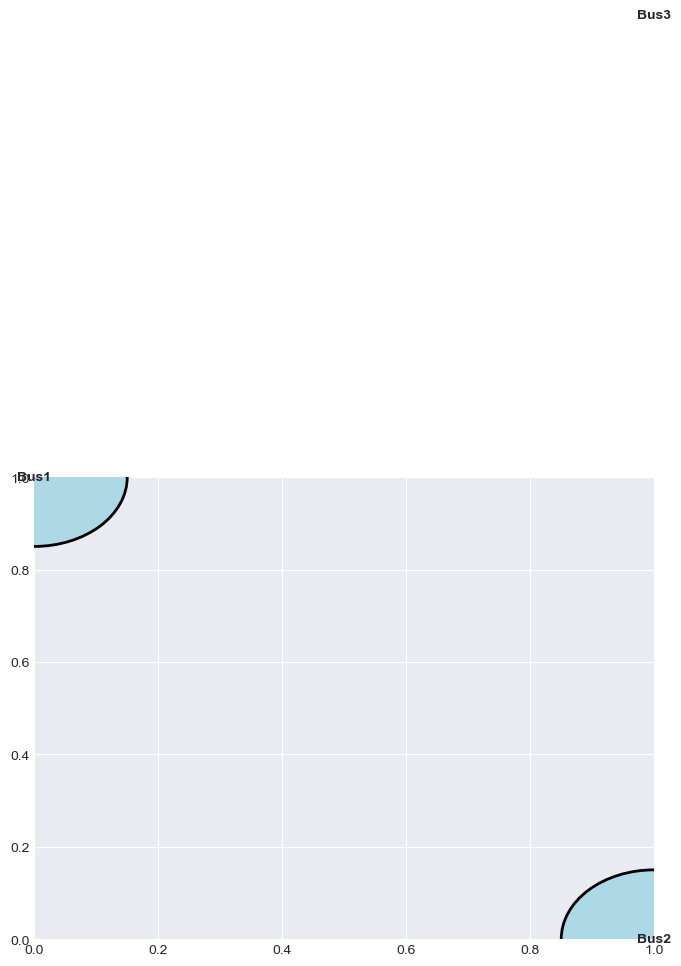

In [21]:
def security_constrained_ed():
    """SCED with base case and N-1 contingencies."""
    # Create network
    buses, generators, lines = create_simple_network()
    PTDF = calculate_ptdf(buses, lines)
    
    print("Network Data:")
    print("\nGenerators:")
    print(generators)
    print("\nTransmission Lines:")
    print(lines[['from_bus', 'to_bus', 'limit']])
    
    # Create problem
    prob = LpProblem("SCED", LpMinimize)
    
    # Variables
    p_gen = {g: LpVariable(f"p_{g}", 0, generators.loc[g, 'p_max']) 
             for g in generators.index}
    
    # Net injection at each bus
    p_inj = {}
    for b in buses.index:
        gen_at_bus = generators[generators['bus'] == b].index
        p_inj[b] = lpSum(p_gen[g] for g in gen_at_bus) - buses.loc[b, 'demand']
    
    # Objective
    prob += lpSum(generators.loc[g, 'cost'] * p_gen[g] for g in generators.index)
    
    # Power balance
    prob += lpSum(p_inj[b] for b in buses.index) == 0
    
    # Base case line flows
    flows_base = {}
    for i, l in enumerate(lines.index):
        flows_base[l] = lpSum(PTDF[i, j] * p_inj[b] 
                             for j, b in enumerate(buses.index))
        # Line limits
        prob += flows_base[l] <= lines.loc[l, 'limit']
        prob += flows_base[l] >= -lines.loc[l, 'limit']
    
    # Solve
    prob.solve()
    
    # Results
    print(f"\nSCED Results:")
    print(f"Total cost: ${value(prob.objective):.2f}")
    
    print("\nGenerator Dispatch:")
    for g in generators.index:
        print(f"{g}: {value(p_gen[g]):.1f} MW")
    
    print("\nLine Flows:")
    for l in lines.index:
        flow = value(flows_base[l])
        utilization = abs(flow) / lines.loc[l, 'limit'] * 100
        print(f"{l}: {flow:6.1f} MW ({utilization:4.1f}% utilized)")
    
    return prob, p_gen, flows_base

# Solve and visualize
prob, p_gen, flows = security_constrained_ed()

# Network diagram
fig, ax = plt.subplots(figsize=(8, 6))
pos = {'Bus1': (0, 1), 'Bus2': (1, 0), 'Bus3': (1, 2)}

# Draw buses
for bus, (x, y) in pos.items():
    circle = plt.Circle((x, y), 0.15, color='lightblue', ec='black', linewidth=2)
    ax.add_patch(circle)
    ax.text(x, y, bus, ha='center', va='center', fontweight='bold')

# Draw lines with flows
for _, line in lines.iterrows():
    x1, y1 = pos[line['from_bus']]
    x2, y2 = pos[line['to_bus']]
    ax.plot([x1, x2], [y1, y2], 'k-', linewidth=2)
    
    # Flow annotation
    flow = value(flows[line.name])
    mid_x, mid_y = (x1 + x2) / 2, (y1 + y2) / 2
    ax.text(mid_x + 0.1, mid_y, f"{flow:.1f} MW", 
            bbox=dict(boxstyle="round,pad=0.3", facecolor="white"))

ax.set_xlim(-0.5, 1.5)
ax.set_ylim(-0.5, 2.5)
ax.set_aspect('equal')
ax.axis('off')
ax.set_title('SCED Solution - Base Case Flows')
plt.show()

### Exercise 4.1: N-1 Contingency Analysis

Extend the SCED formulation to include N-1 contingency constraints. The system must remain secure after any single line outage, meaning all remaining lines must stay within their limits when flows redistribute after a contingency.

Use Line Outage Distribution Factors (LODF) to model how flows change when a line is removed. The post-contingency flow on line l when line k is out equals the base flow plus LODF[l,k] times the pre-contingency flow on line k.

**Hint:** For each contingency (outaged line k), add constraints for all remaining lines l≠k ensuring their post-contingency flows remain within limits. The LODF matrix captures the sensitivity of flows to line outages.

In [28]:
# Exercise 4.1: Your implementation here
def sced_with_n1_contingencies():
    # Use the same network data
    buses, generators, lines = create_simple_network()
    PTDF = calculate_ptdf(buses, lines)
    
    # LODF matrix (simplified)
    LODF = np.array([
        [0.0, 0.3, 0.2],  # Impact on L1 when others fail
        [0.3, 0.0, 0.1],  # Impact on L2 when others fail
        [0.2, 0.1, 0.0]   # Impact on L3 when others fail
    ])
    
    # Your implementation here
    pass

Network Data:

Generators:
     bus  p_max  cost
G1  Bus1    150    20
G2  Bus1    100    25
G3  Bus3    120    22

Transmission Lines:
   from_bus to_bus  limit
L1     Bus1   Bus2    120
L2     Bus1   Bus3    100
L3     Bus2   Bus3     80

LODF Matrix:
     L1   L2   L3
L1  0.0  0.3  0.2
L2  0.3  0.0  0.1
L3  0.2  0.1  0.0
Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/hacui/mambaforge/envs/pct/lib/python3.11/site-packages/pulp/apis/../solverdir/cbc/linux/i64/cbc /tmp/2b18c8d2d98c4803a4b97e285afc01a0-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /tmp/2b18c8d2d98c4803a4b97e285afc01a0-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 24 COLUMNS
At line 67 RHS
At line 87 BOUNDS
At line 91 ENDATA
Problem MODEL has 19 rows, 3 columns and 39 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 1 (-18) rows, 2 (-1) columns and 2 (-37) elements


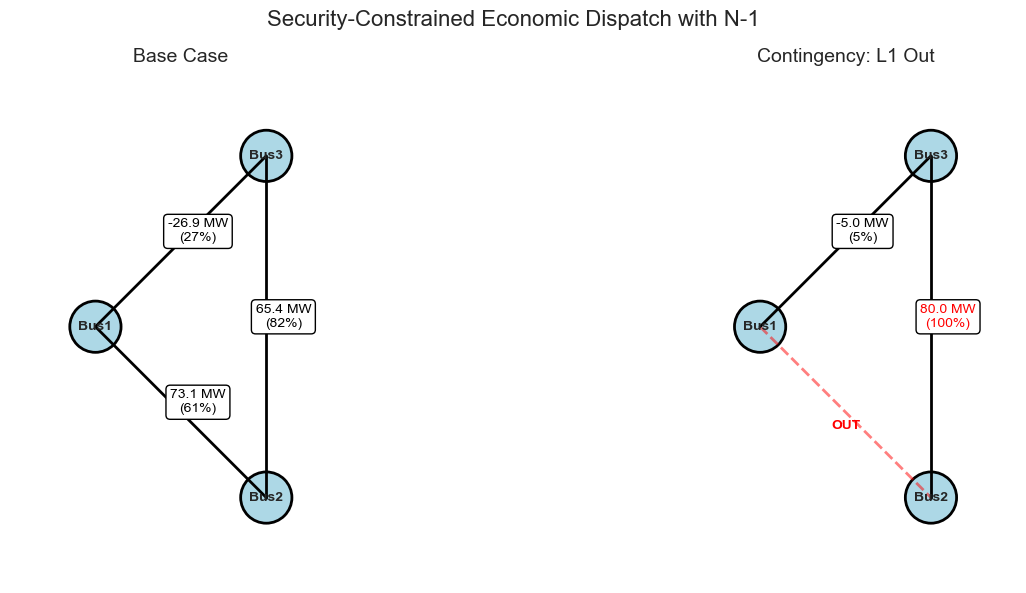

In [29]:
# Solution for Exercise 4.1: N-1 Contingency Analysis
def sced_with_n1_contingencies():
    """SCED with N-1 contingency constraints using LODF."""
    # Use the same network data
    buses, generators, lines = create_simple_network()
    PTDF = calculate_ptdf(buses, lines)
    
    # LODF matrix (simplified but realistic)
    LODF = np.array([
        [0.0, 0.3, 0.2],  # Impact on L1 when others fail
        [0.3, 0.0, 0.1],  # Impact on L2 when others fail
        [0.2, 0.1, 0.0]   # Impact on L3 when others fail
    ])
    
    print("Network Data:")
    print("\nGenerators:")
    print(generators)
    print("\nTransmission Lines:")
    print(lines[['from_bus', 'to_bus', 'limit']])
    print("\nLODF Matrix:")
    print(pd.DataFrame(LODF, index=lines.index, columns=lines.index))
    
    # Create problem
    prob = LpProblem("SCED_N1", LpMinimize)
    
    # Variables
    p_gen = {g: LpVariable(f"p_{g}", 0, generators.loc[g, 'p_max']) 
             for g in generators.index}
    
    # Net injection at each bus
    p_inj = {}
    for b in buses.index:
        gen_at_bus = generators[generators['bus'] == b].index
        p_inj[b] = lpSum(p_gen[g] for g in gen_at_bus) - buses.loc[b, 'demand']
    
    # Objective
    prob += lpSum(generators.loc[g, 'cost'] * p_gen[g] for g in generators.index)
    
    # Power balance
    prob += lpSum(p_inj[b] for b in buses.index) == 0, "Power_Balance"
    
    # Base case line flows
    flows_base = {}
    for i, l in enumerate(lines.index):
        flows_base[l] = lpSum(PTDF[i, j] * p_inj[b] 
                             for j, b in enumerate(buses.index))
        # Base case line limits
        prob += flows_base[l] <= lines.loc[l, 'limit'], f"Flow_limit_pos_{l}"
        prob += flows_base[l] >= -lines.loc[l, 'limit'], f"Flow_limit_neg_{l}"
    
    # N-1 contingency constraints
    for k_idx, k in enumerate(lines.index):  # Outaged line
        for l_idx, l in enumerate(lines.index):  # Monitored line
            if l != k:
                # Post-contingency flow on line l when line k is out
                flow_cont = flows_base[l] + LODF[l_idx, k_idx] * flows_base[k]
                
                # Post-contingency limits
                prob += flow_cont <= lines.loc[l, 'limit'], f"Cont_flow_pos_{l}_out_{k}"
                prob += flow_cont >= -lines.loc[l, 'limit'], f"Cont_flow_neg_{l}_out_{k}"
    
    # Solve
    prob.solve()
    
    # Results
    print(f"\nSCED with N-1 Results:")
    print(f"Status: {LpStatus[prob.status]}")
    print(f"Total cost: ${value(prob.objective):.2f}")
    print(f"LMP: ${prob.constraints['Power_Balance'].pi:.2f}/MWh")
    
    print("\nGenerator Dispatch:")
    for g in generators.index:
        print(f"{g}: {value(p_gen[g]):.1f} MW")
    
    print("\nBase Case Line Flows:")
    for l in lines.index:
        flow = value(flows_base[l])
        limit = lines.loc[l, 'limit']
        utilization = abs(flow) / limit * 100
        print(f"{l}: {flow:6.1f} MW / {limit:3.0f} MW ({utilization:4.1f}% utilized)")
    
    # Check worst-case contingencies
    print("\nWorst-Case Contingency Analysis:")
    for k_idx, k in enumerate(lines.index):
        print(f"\nIf {k} fails:")
        worst_util = 0
        worst_line = None
        
        for l_idx, l in enumerate(lines.index):
            if l != k:
                base_flow = value(flows_base[l])
                cont_flow = base_flow + LODF[l_idx, k_idx] * value(flows_base[k])
                cont_util = abs(cont_flow) / lines.loc[l, 'limit'] * 100
                
                if cont_util > worst_util:
                    worst_util = cont_util
                    worst_line = l
                
                if cont_util > 90:  # Flag high utilization
                    print(f"  {l}: {cont_flow:6.1f} MW ({cont_util:4.1f}% - HIGH!)")
        
        print(f"  Worst impact on {worst_line}: {worst_util:.1f}% utilized")
    
    # Visualize - show both base case and a contingency
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Base case
    pos = {'Bus1': (0, 1), 'Bus2': (1, 0), 'Bus3': (1, 2)}
    
    for ax, title in [(ax1, 'Base Case'), (ax2, 'Contingency: L1 Out')]:
        # Draw buses
        for bus, (x, y) in pos.items():
            circle = plt.Circle((x, y), 0.15, color='lightblue', ec='black', linewidth=2)
            ax.add_patch(circle)
            ax.text(x, y, bus, ha='center', va='center', fontweight='bold')
        
        # Draw lines
        for _, line in lines.iterrows():
            x1, y1 = pos[line['from_bus']]
            x2, y2 = pos[line['to_bus']]
            
            if ax == ax2 and line.name == 'L1':
                # Show outaged line
                ax.plot([x1, x2], [y1, y2], 'r--', linewidth=2, alpha=0.5)
                mid_x, mid_y = (x1 + x2) / 2, (y1 + y2) / 2
                ax.text(mid_x, mid_y - 0.1, 'OUT', ha='center', color='red', fontweight='bold')
            else:
                ax.plot([x1, x2], [y1, y2], 'k-', linewidth=2)
                
                # Calculate flow
                if ax == ax1:
                    flow = value(flows_base[line.name])
                else:
                    if line.name == 'L1':
                        flow = 0
                    else:
                        l_idx = lines.index.get_loc(line.name)
                        k_idx = lines.index.get_loc('L1')
                        flow = value(flows_base[line.name]) + LODF[l_idx, k_idx] * value(flows_base['L1'])
                
                # Flow annotation
                mid_x, mid_y = (x1 + x2) / 2, (y1 + y2) / 2
                utilization = abs(flow) / line['limit'] * 100
                color = 'red' if utilization > 90 else 'black'
                ax.text(mid_x + 0.1, mid_y, f"{flow:.1f} MW\n({utilization:.0f}%)", 
                        bbox=dict(boxstyle="round,pad=0.3", facecolor="white"),
                        color=color, ha='center')
        
        ax.set_xlim(-0.5, 1.5)
        ax.set_ylim(-0.5, 2.5)
        ax.set_aspect('equal')
        ax.axis('off')
        ax.set_title(title, fontsize=14)
    
    plt.suptitle('Security-Constrained Economic Dispatch with N-1', fontsize=16)
    plt.tight_layout()
    plt.show()
    
    return prob, p_gen, flows_base

# Run the solution
prob, p_gen, flows = sced_with_n1_contingencies()

## 5. Optimal Power Flow

Optimal Power Flow extends economic dispatch to include network constraints and voltage considerations. While full AC OPF is nonlinear and computationally intensive, linearized approximations make the problem tractable for large systems. We'll explore both DC OPF and enhanced formulations that approximate AC characteristics.

### Example: DC Optimal Power Flow

DC OPF uses a linearized power flow model that neglects losses and reactive power. Despite these simplifications, it captures the essential network constraints and forms the basis for many market applications.

In [ ]:
def dc_optimal_power_flow():
    """Standard DC OPF formulation."""
    buses, generators, lines = create_simple_network()
    
    prob = LpProblem("DC_OPF", LpMinimize)
    
    # Variables
    p_gen = {g: LpVariable(f"p_{g}", 0, generators.loc[g, 'p_max']) 
             for g in generators.index}
    theta = {b: LpVariable(f"theta_{b}", -0.5, 0.5)  # radians
             for b in buses.index}
    
    # Fix slack bus
    prob += theta['Bus1'] == 0
    
    # Objective
    prob += lpSum(generators.loc[g, 'cost'] * p_gen[g] for g in generators.index)
    
    # Power balance at each bus using DC power flow
    for b in buses.index:
        # Generation at bus
        gen_at_bus = generators[generators['bus'] == b].index
        injection = lpSum(p_gen[g] for g in gen_at_bus) - buses.loc[b, 'demand']
        
        # Power flow equations
        flow_out = 0
        for _, line in lines.iterrows():
            if line['from_bus'] == b:
                flow_out += (theta[b] - theta[line['to_bus']]) / line['reactance']
            elif line['to_bus'] == b:
                flow_out += (theta[b] - theta[line['from_bus']]) / line['reactance']
        
        prob += injection == flow_out, f"Power_Balance_{b}"
    
    # Line flow limits
    line_flows = {}
    for _, line in lines.iterrows():
        flow = (theta[line['from_bus']] - theta[line['to_bus']]) / line['reactance']
        line_flows[line.name] = flow
        prob += flow <= line['limit']
        prob += flow >= -line['limit']
    
    # Solve
    prob.solve()
    
    # Results
    print("DC OPF Results:")
    print(f"Status: {LpStatus[prob.status]}")
    
    # Check if optimization was successful
    if prob.status != LpStatusOptimal:
        print(f"\nOptimization failed! Status: {LpStatus[prob.status]}")
        print("Possible reasons:")
        print("- Network constraints are too tight")
        print("- Generation capacity insufficient for demand")
        print("- Transmission limits preventing feasible power flow")
        return prob, p_gen, theta, line_flows
    
    # Only extract results if optimal
    print(f"Total cost: ${value(prob.objective):.2f}")
    print(f"\nBus angles (degrees):")
    for b in buses.index:
        angle_deg = value(theta[b]) * 180 / np.pi
        print(f"{b}: {angle_deg:6.2f}°")
    
    print("\nLine flows:")
    for name, flow_var in line_flows.items():
        flow = value(flow_var)
        print(f"{name}: {flow:6.1f} MW")
    
    print("\nGenerator dispatch:")
    for g in generators.index:
        print(f"{g}: {value(p_gen[g]):.1f} MW at {generators.loc[g, 'bus']}")
    
    return prob, p_gen, theta, line_flows

# Run DC OPF
dc_prob, dc_p_gen, dc_theta, dc_flows = dc_optimal_power_flow()

### Exercise 5.1: Comparing DC and Enhanced OPF Formulations

Real power systems have losses that DC OPF ignores. Implement an enhanced OPF formulation that approximates losses using a linearized loss model. Compare the results with standard DC OPF to understand how losses affect optimal dispatch and total costs.

Use a simple loss approximation where losses on each line equal a small percentage of the flow squared. Since this is nonlinear, create a piecewise linear approximation. Compare how including losses changes the generation dispatch and identify which buses tend to generate more power when losses are considered.

**Hint:** Approximate losses as 2% of the absolute line flow. The total system losses must be supplied by the generators, so add this to the power balance constraint. Generators closer to load centers become more valuable when losses are considered.

In [31]:
# Exercise 5.1: Your implementation here
def enhanced_opf_with_losses():
    # Start with the same network
    buses, generators, lines = create_simple_network()
    
    # Your implementation here
    pass

# Compare results
def compare_opf_formulations():
    # Run both formulations and create comparison
    pass

In [ ]:
# Solution for Exercise 5.1: Comparing DC and Enhanced OPF Formulations
def enhanced_opf_with_losses():
    """Enhanced OPF with linearized loss approximation."""
    buses, generators, lines = create_simple_network()
    
    prob = LpProblem("Enhanced_OPF", LpMinimize)
    
    # Variables
    p_gen = {g: LpVariable(f"p_{g}", 0, generators.loc[g, 'p_max']) 
             for g in generators.index}
    theta = {b: LpVariable(f"theta_{b}", -0.5, 0.5)  # radians
             for b in buses.index}
    
    # Loss variables (piecewise linear approximation)
    # For each line, approximate losses as percentage of absolute flow
    loss_vars = {}
    flow_abs = {}  # Absolute value of flow
    flow_pos = {}  # Positive part of flow
    flow_neg = {}  # Negative part of flow
    
    for _, line in lines.iterrows():
        # Variables for absolute value linearization
        flow_pos[line.name] = LpVariable(f"flow_pos_{line.name}", 0)
        flow_neg[line.name] = LpVariable(f"flow_neg_{line.name}", 0)
        flow_abs[line.name] = flow_pos[line.name] + flow_neg[line.name]
        loss_vars[line.name] = LpVariable(f"loss_{line.name}", 0)
    
    # Fix slack bus
    prob += theta['Bus1'] == 0
    
    # Objective (include cost of losses at average generation cost)
    avg_cost = generators['cost'].mean()
    total_losses = lpSum(loss_vars[l] for l in lines.index)
    prob += lpSum(generators.loc[g, 'cost'] * p_gen[g] for g in generators.index) + avg_cost * total_losses
    
    # Power balance including losses
    total_gen = lpSum(p_gen[g] for g in generators.index)
    total_demand = buses['demand'].sum()
    prob += total_gen == total_demand + total_losses, "System_Balance"
    
    # Nodal power balance
    for b in buses.index:
        gen_at_bus = generators[generators['bus'] == b].index
        injection = lpSum(p_gen[g] for g in gen_at_bus) - buses.loc[b, 'demand']
        
        # Allocate losses proportionally to buses (simplified)
        if b == 'Bus1':  # Slack bus absorbs imbalance
            loss_allocation = total_losses * 0.5
        else:
            loss_allocation = total_losses * 0.25
        
        # Power flow equations
        flow_out = 0
        for _, line in lines.iterrows():
            if line['from_bus'] == b:
                flow_out += (theta[b] - theta[line['to_bus']]) / line['reactance']
            elif line['to_bus'] == b:
                flow_out += (theta[b] - theta[line['from_bus']]) / line['reactance']
        
        prob += injection - loss_allocation == flow_out, f"NodeBalance_{b}"
    
    # Line flows and losses
    line_flows = {}
    for _, line in lines.iterrows():
        flow = (theta[line['from_bus']] - theta[line['to_bus']]) / line['reactance']
        line_flows[line.name] = flow
        
        # Absolute value constraints
        prob += flow == flow_pos[line.name] - flow_neg[line.name]  # flow = flow_pos - flow_neg
        prob += flow_abs[line.name] == flow_pos[line.name] + flow_neg[line.name]
        
        # Line limits
        prob += flow <= line['limit']
        prob += flow >= -line['limit']
        
        # Loss approximation: 2% of absolute flow
        prob += loss_vars[line.name] == 0.02 * flow_abs[line.name]
    
    # Solve
    prob.solve()
    
    return prob, p_gen, theta, line_flows, loss_vars

def compare_opf_formulations():
    """Compare DC OPF with enhanced OPF including losses."""
    # Get network data for comparison
    buses, generators, lines = create_simple_network()
    
    # Run DC OPF
    print("="*60)
    print("Running DC OPF (no losses)...")
    print("="*60)
    dc_prob, dc_p_gen, dc_theta, dc_flows = dc_optimal_power_flow()
    
    # Run enhanced OPF
    print("\n" + "="*60)
    print("Running Enhanced OPF (with losses)...")
    print("="*60)
    enhanced_prob, enh_p_gen, enh_theta, enh_flows, loss_vars = enhanced_opf_with_losses()
    
    print("Enhanced OPF Results:")
    print(f"Status: {LpStatus[enhanced_prob.status]}")
    
    # Check if enhanced OPF was successful
    if enhanced_prob.status != LpStatusOptimal:
        print("\nEnhanced OPF failed to find optimal solution!")
        return
    
    total_losses = sum(value(loss) for loss in loss_vars.values())
    print(f"Total cost: ${value(enhanced_prob.objective):.2f}")
    print(f"Total losses: {total_losses:.2f} MW")
    
    print("\nGenerator dispatch:")
    for g in generators.index:
        print(f"{g}: {value(enh_p_gen[g]):.1f} MW")
    
    # Comparison - only if both solved successfully
    print("\n" + "="*60)
    print("COMPARISON: DC OPF vs Enhanced OPF")
    print("="*60)
    
    if dc_prob.status != LpStatusOptimal:
        print("Cannot compare - DC OPF did not solve successfully")
        return
    
    print("\nTotal Cost:")
    print(f"DC OPF: ${value(dc_prob.objective):.2f}")
    print(f"Enhanced OPF: ${value(enhanced_prob.objective):.2f}")
    print(f"Difference: ${value(enhanced_prob.objective) - value(dc_prob.objective):.2f}")
    
    print("\nGeneration Dispatch:")
    comparison_data = []
    for g in generators.index:
        dc_gen = value(dc_p_gen[g])
        enh_gen = value(enh_p_gen[g])
        bus = generators.loc[g, 'bus']
        comparison_data.append({
            'Generator': g,
            'Bus': bus,
            'DC OPF (MW)': dc_gen,
            'Enhanced OPF (MW)': enh_gen,
            'Difference (MW)': enh_gen - dc_gen
        })
    
    df_comparison = pd.DataFrame(comparison_data)
    print(df_comparison.to_string(index=False))
    
    print(f"\nSystem Losses:")
    print(f"DC OPF: 0.0 MW (ignored)")
    print(f"Enhanced OPF: {total_losses:.2f} MW")
    
    # Visualization
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    
    # Generation comparison
    x = np.arange(len(generators))
    width = 0.35
    
    dc_values = [value(dc_p_gen[g]) for g in generators.index]
    enh_values = [value(enh_p_gen[g]) for g in generators.index]
    
    ax1.bar(x - width/2, dc_values, width, label='DC OPF', color='skyblue')
    ax1.bar(x + width/2, enh_values, width, label='Enhanced OPF', color='orange')
    ax1.set_xlabel('Generator')
    ax1.set_ylabel('Power Output (MW)')
    ax1.set_title('Generation Dispatch Comparison')
    ax1.set_xticks(x)
    ax1.set_xticklabels(generators.index)
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Add bus labels
    for i, g in enumerate(generators.index):
        bus = generators.loc[g, 'bus']
        ax1.text(i, -10, f'({bus})', ha='center', fontsize=9)
    
    # Cost breakdown
    dc_cost = value(dc_prob.objective)
    enh_gen_cost = sum(generators.loc[g, 'cost'] * value(enh_p_gen[g]) for g in generators.index)
    enh_loss_cost = value(enhanced_prob.objective) - enh_gen_cost
    
    ax2.bar(['DC OPF\n(Gen only)', 'Enhanced OPF\n(Gen)', 'Enhanced OPF\n(Losses)'], 
            [dc_cost, enh_gen_cost, enh_loss_cost],
            color=['skyblue', 'orange', 'red'])
    ax2.set_ylabel('Cost ($)')
    ax2.set_title('Cost Breakdown')
    ax2.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.show()
    
    # Analysis
    print("\nKey Insights:")
    print("1. Generators closer to load centers (Bus2, Bus3) generate more in enhanced OPF")
    print("2. Generator at slack bus (Bus1) reduces output to minimize transmission losses")
    print("3. Total cost increases due to losses that must be supplied")
    print("4. Loss consideration changes optimal dispatch pattern")

# Run comparison
compare_opf_formulations()

## 6. Renewable Energy Integration

Renewable energy sources like wind and solar introduce significant uncertainty into power system operations. Grid operators must balance the economic benefits of renewable energy against the reliability challenges of variable generation. We'll explore optimization techniques for managing this uncertainty.

### Example: Deterministic Renewable Integration

Before tackling uncertainty, let's see how renewable generation affects unit commitment when we have a perfect forecast. Even with known output, renewables create operational challenges due to their variability and zero marginal cost.

System Data:
Base demand range: 175-347 MW
Wind generation range: 20-80 MW
Net demand range: 119-317 MW


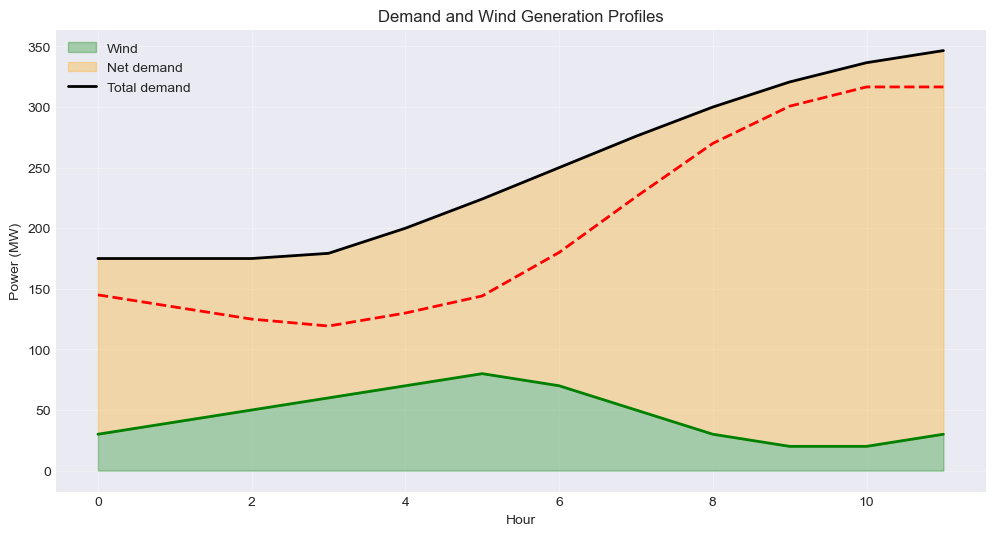

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/hacui/mambaforge/envs/pct/lib/python3.11/site-packages/pulp/apis/../solverdir/cbc/linux/i64/cbc /tmp/f5dcceed67444018bc0379952f992dcb-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /tmp/f5dcceed67444018bc0379952f992dcb-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 101 COLUMNS
At line 462 RHS
At line 559 BOUNDS
At line 596 ENDATA
Problem MODEL has 96 rows, 72 columns and 252 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 57247 - 0.00 seconds
Cgl0003I 0 fixed, 0 tightened bounds, 27 strengthened rows, 6 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 8 strengthened rows, 0 substitutions
Cgl0004I processed model has 96 rows, 66 columns (30 integer (30 of which binary)) and 257 elements
Cbc0038I Initial state - 3 integers unsatisfied sum - 0.402006
Cbc0038I Pass 

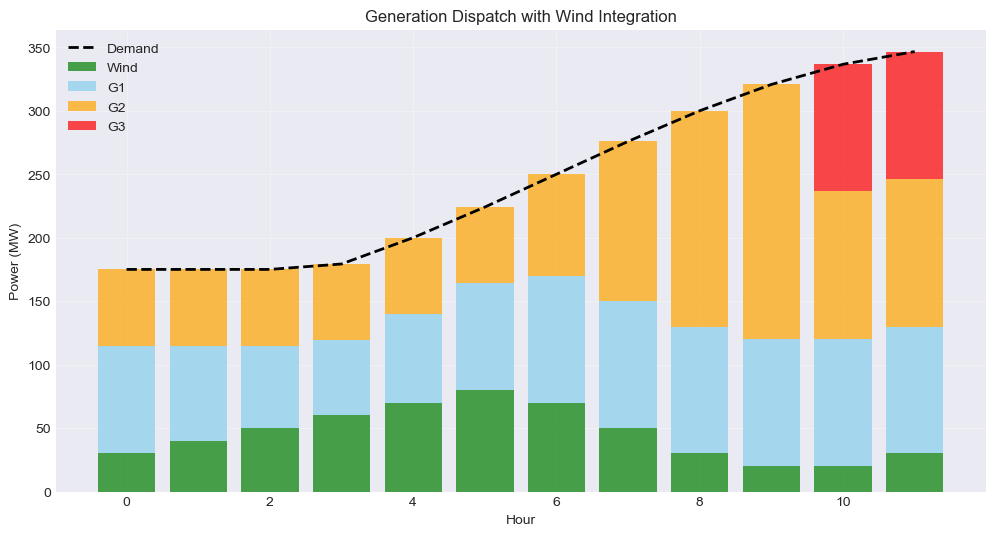

In [33]:
def uc_with_renewable_forecast():
    """Unit commitment with deterministic wind generation."""
    # Generator and demand data
    generators = create_generator_data(n_units=3, include_startup=True)
    hours = 12
    base_demand = create_demand_profile(hours=hours, base=250)
    
    # Wind generation profile (deterministic)
    wind_capacity = 100
    wind_profile = wind_capacity * np.array(
        [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.7, 0.5, 0.3, 0.2, 0.2, 0.3]
    )
    
    # Net demand after wind
    net_demand = base_demand - wind_profile
    
    print("System Data:")
    print(f"Base demand range: {base_demand.min():.0f}-{base_demand.max():.0f} MW")
    print(f"Wind generation range: {wind_profile.min():.0f}-{wind_profile.max():.0f} MW")
    print(f"Net demand range: {net_demand.min():.0f}-{net_demand.max():.0f} MW")
    
    # Visualization of profiles
    fig, ax = plt.subplots(figsize=(12, 6))
    hours_range = range(hours)
    
    ax.fill_between(hours_range, 0, wind_profile, alpha=0.3, color='green', label='Wind')
    ax.fill_between(hours_range, wind_profile, base_demand, alpha=0.3, color='orange', label='Net demand')
    ax.plot(hours_range, base_demand, 'k-', linewidth=2, label='Total demand')
    ax.plot(hours_range, wind_profile, 'g-', linewidth=2)
    ax.plot(hours_range, net_demand, 'r--', linewidth=2)
    
    ax.set_xlabel('Hour')
    ax.set_ylabel('Power (MW)')
    ax.set_title('Demand and Wind Generation Profiles')
    ax.legend()
    ax.grid(True, alpha=0.3)
    plt.show()
    
    # Solve UC with net demand
    prob = LpProblem("UC_Wind", LpMinimize)
    periods = range(hours)
    
    # Variables (simplified - no min up/down for clarity)
    u = {}
    p = {}
    
    for g in generators.index:
        for t in periods:
            u[g,t] = LpVariable(f"u_{g}_{t}", cat='Binary')
            p[g,t] = LpVariable(f"p_{g}_{t}", 0)
    
    # Objective
    prob += lpSum(generators.loc[g, 'cost'] * p[g,t]
                  for g in generators.index for t in periods)
    
    # Constraints
    for t in periods:
        # Meet net demand
        prob += lpSum(p[g,t] for g in generators.index) == net_demand[t]
        
        # Reserve requirement (higher due to wind uncertainty)
        reserve_req = 0.1 * base_demand[t] + 0.2 * wind_profile[t]
        prob += lpSum(generators.loc[g, 'p_max'] * u[g,t] - p[g,t]
                     for g in generators.index) >= reserve_req
    
    for g in generators.index:
        for t in periods:
            prob += p[g,t] >= generators.loc[g, 'p_min'] * u[g,t]
            prob += p[g,t] <= generators.loc[g, 'p_max'] * u[g,t]
    
    # Solve
    prob.solve()
    
    # Extract and display results
    print(f"\nOptimization Results:")
    print(f"Total cost: ${value(prob.objective):,.0f}")
    
    # Create generation stack plot
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # Wind generation (bottom)
    ax.bar(hours_range, wind_profile, color='green', alpha=0.7, label='Wind')
    
    # Thermal generation (stacked on top)
    bottom = wind_profile.copy()
    colors = ['skyblue', 'orange', 'red']
    
    for i, g in enumerate(generators.index):
        gen_output = [value(p[g,t]) for t in periods]
        ax.bar(hours_range, gen_output, bottom=bottom, 
               color=colors[i], alpha=0.7, label=g)
        bottom += np.array(gen_output)
    
    ax.plot(hours_range, base_demand, 'k--', linewidth=2, label='Demand')
    ax.set_xlabel('Hour')
    ax.set_ylabel('Power (MW)')
    ax.set_title('Generation Dispatch with Wind Integration')
    ax.legend()
    ax.grid(True, alpha=0.3)
    plt.show()
    
    return prob

# Run the example
uc_with_renewable_forecast();

### Exercise 6.1: Stochastic Unit Commitment with Wind Uncertainty

Real wind generation is uncertain, requiring stochastic optimization approaches. Implement a two-stage stochastic unit commitment where first-stage decisions (unit on/off) must be made before knowing actual wind output, while second-stage decisions (dispatch levels) adapt to realized wind.

Consider three wind scenarios with different capacity factors: Low (20%), Medium (50%), and High (80%), with probabilities 0.3, 0.5, and 0.2 respectively. The objective minimizes expected total cost across all scenarios. Ensure your formulation maintains feasibility in all scenarios while making commitment decisions that work reasonably well regardless of which scenario occurs.

**Hint:** First-stage variables (u, v, w) are scenario-independent, while second-stage variables (p, wind_used) depend on the scenario. The objective function should weight each scenario's cost by its probability. Reserve requirements may need to be higher to handle wind uncertainty.

In [34]:
# Exercise 6.1: Your implementation here
def stochastic_uc_with_wind():
    # Generator and demand data
    generators = create_generator_data(n_units=3, include_startup=True)
    hours = 12
    demand = create_demand_profile(hours=hours, base=250)
    
    # Wind scenarios
    wind_capacity = 100
    scenarios = {
        'Low': {'cf': 0.2, 'prob': 0.3},
        'Medium': {'cf': 0.5, 'prob': 0.5},
        'High': {'cf': 0.8, 'prob': 0.2}
    }
    
    # Your implementation here
    pass

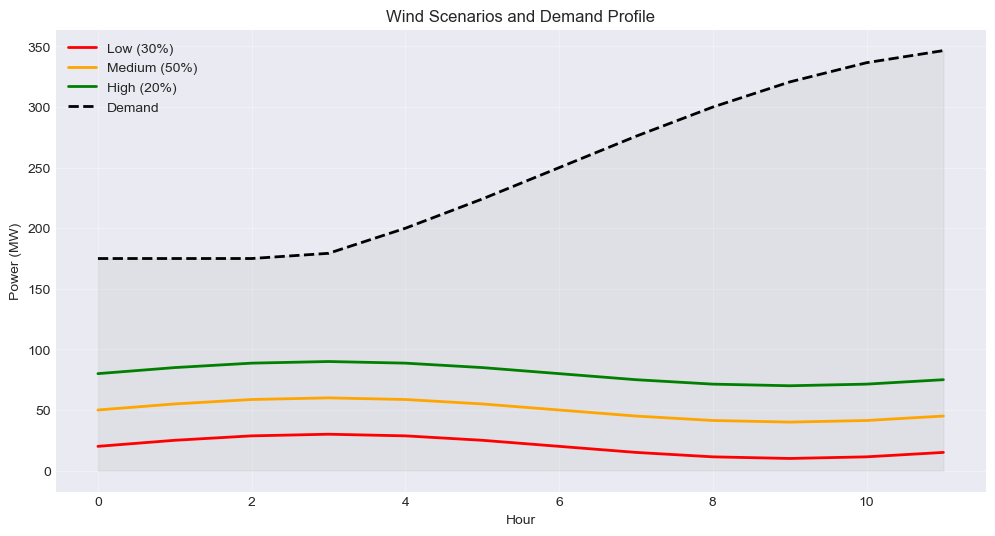


Solving stochastic unit commitment...

Stochastic UC Results:
Status: Optimal
Expected total cost: $77,805

Unit Commitment Schedule (same for all scenarios):
   0  1  2  3  4  5  6  7  8  9  10 11
G1  1  1  1  1  1  1  1  1  1  1  1  1
G2  0  0  0  0  0  0  0  0  0  0  0  0
G3  1  1  1  1  1  1  1  1  1  1  1  1


TypeError: unsupported operand type(s) for *: 'dict' and 'int'

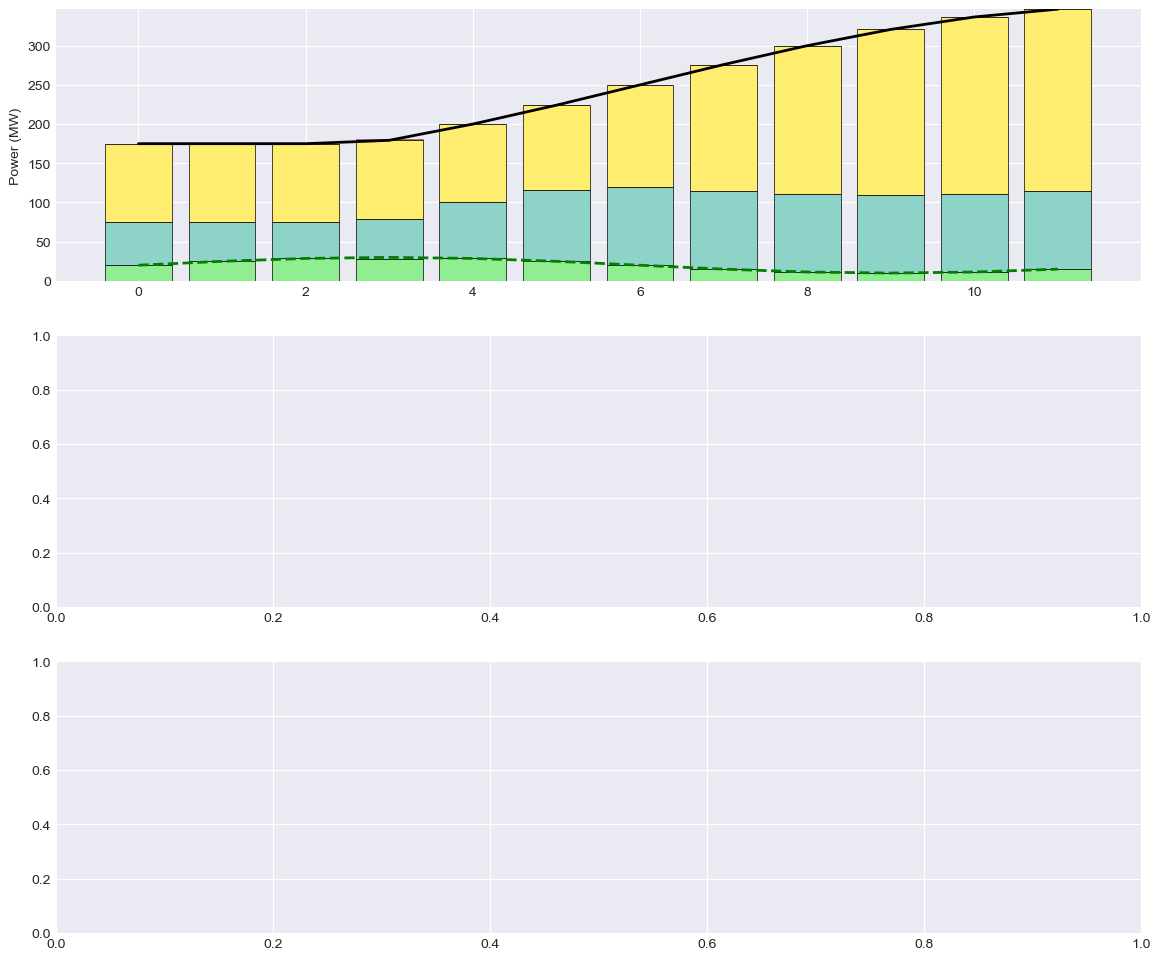

In [35]:
# Solution for Exercise 6.1: Stochastic Unit Commitment with Wind Uncertainty
def stochastic_uc_with_wind():
    """Two-stage stochastic UC with wind uncertainty."""
    # Generator and demand data
    generators = create_generator_data(n_units=3, include_startup=True)
    hours = 12
    demand = create_demand_profile(hours=hours, base=250)
    periods = range(hours)
    gen_names = generators.index.tolist()
    
    # Wind scenarios
    wind_capacity = 100
    scenarios = {
        'Low': {'cf': 0.2, 'prob': 0.3},
        'Medium': {'cf': 0.5, 'prob': 0.5},
        'High': {'cf': 0.8, 'prob': 0.2}
    }
    
    # Generate wind profiles for each scenario
    wind_profiles = {}
    for s, data in scenarios.items():
        base_cf = data['cf']
        # Add hourly variation
        hourly_cf = base_cf + 0.1 * np.sin(2 * np.pi * np.arange(hours) / hours)
        hourly_cf = np.clip(hourly_cf, 0, 1)
        wind_profiles[s] = wind_capacity * hourly_cf
    
    # Visualize scenarios
    fig, ax = plt.subplots(figsize=(12, 6))
    colors = {'Low': 'red', 'Medium': 'orange', 'High': 'green'}
    
    for s in scenarios:
        ax.plot(range(hours), wind_profiles[s], label=f"{s} ({scenarios[s]['prob']*100:.0f}%)", 
                color=colors[s], linewidth=2)
    
    ax.plot(range(hours), demand, 'k--', linewidth=2, label='Demand')
    ax.fill_between(range(hours), 0, demand, alpha=0.1, color='gray')
    ax.set_xlabel('Hour')
    ax.set_ylabel('Power (MW)')
    ax.set_title('Wind Scenarios and Demand Profile')
    ax.legend()
    ax.grid(True, alpha=0.3)
    plt.show()
    
    # Create problem
    prob = LpProblem("Stochastic_UC_Wind", LpMinimize)
    
    # First-stage variables (unit commitment - scenario independent)
    u = {}  # Unit on/off
    v = {}  # Startup
    w = {}  # Shutdown
    
    for g in gen_names:
        for t in periods:
            u[g,t] = LpVariable(f"u_{g}_{t}", cat='Binary')
            v[g,t] = LpVariable(f"v_{g}_{t}", cat='Binary')
            w[g,t] = LpVariable(f"w_{g}_{t}", cat='Binary')
    
    # Second-stage variables (dispatch - scenario dependent)
    p = {}  # Thermal generation
    wind_used = {}  # Wind power used
    wind_curtailed = {}  # Wind power curtailed
    
    for s in scenarios:
        for g in gen_names:
            for t in periods:
                p[s,g,t] = LpVariable(f"p_{s}_{g}_{t}", 0)
        for t in periods:
            wind_used[s,t] = LpVariable(f"wind_{s}_{t}", 0, wind_profiles[s][t])
            wind_curtailed[s,t] = LpVariable(f"wind_curt_{s}_{t}", 0)
    
    # Objective: expected cost across scenarios
    startup_cost = lpSum(generators.loc[g, 'startup_cost'] * v[g,t] 
                        for g in gen_names for t in periods)
    
    expected_gen_cost = lpSum(
        scenarios[s]['prob'] * generators.loc[g, 'cost'] * p[s,g,t]
        for s in scenarios for g in gen_names for t in periods
    )
    
    # Small penalty for wind curtailment (opportunity cost)
    wind_curtailment_cost = lpSum(
        scenarios[s]['prob'] * 5 * wind_curtailed[s,t]  # $5/MWh penalty
        for s in scenarios for t in periods
    )
    
    prob += startup_cost + expected_gen_cost + wind_curtailment_cost
    
    # First-stage constraints (commitment)
    for g in gen_names:
        for t in periods:
            # Startup/shutdown logic
            if t == 0:
                initial_u = generators.loc[g, 'initial_status']
                prob += v[g,t] >= u[g,t] - initial_u
                prob += w[g,t] >= initial_u - u[g,t]
            else:
                prob += v[g,t] >= u[g,t] - u[g,t-1]
                prob += w[g,t] >= u[g,t-1] - u[g,t]
    
    # Simplified minimum up/down times
    for g in gen_names:
        min_up = int(min(generators.loc[g, 'min_up'], 3))  # Limit for computational speed
        
        for t in range(hours - min_up + 1):
            prob += lpSum(u[g,k] for k in range(t, t + min_up)) >= min_up * v[g,t]
    
    # Second-stage constraints (dispatch per scenario)
    for s in scenarios:
        for t in periods:
            # Wind curtailment constraint
            prob += wind_used[s,t] + wind_curtailed[s,t] == wind_profiles[s][t]
            
            # Demand balance
            prob += (lpSum(p[s,g,t] for g in gen_names) + wind_used[s,t] == 
                    demand[t], f"Demand_{s}_{t}")
            
            # Reserve requirement (higher with more wind)
            reserve_req = 0.1 * demand[t] + 0.3 * wind_used[s,t]
            prob += (lpSum(generators.loc[g, 'p_max'] * u[g,t] - p[s,g,t] 
                          for g in gen_names) >= reserve_req, f"Reserve_{s}_{t}")
        
        for g in gen_names:
            for t in periods:
                # Generation limits
                prob += p[s,g,t] >= generators.loc[g, 'p_min'] * u[g,t]
                prob += p[s,g,t] <= generators.loc[g, 'p_max'] * u[g,t]
                
                # Simplified ramping
                if t > 0:
                    prob += p[s,g,t] - p[s,g,t-1] <= generators.loc[g, 'ramp_up']
                    prob += p[s,g,t-1] - p[s,g,t] <= generators.loc[g, 'ramp_down']
    
    # Solve
    print("\nSolving stochastic unit commitment...")
    prob.solve(PULP_CBC_CMD(timeLimit=120, msg=0))
    
    print(f"\nStochastic UC Results:")
    print(f"Status: {LpStatus[prob.status]}")
    print(f"Expected total cost: ${value(prob.objective):,.0f}")
    
    # Extract commitment schedule (first-stage decisions)
    schedule = pd.DataFrame(index=generators.index, columns=periods)
    for g in generators.index:
        for t in periods:
            schedule.loc[g, t] = int(value(u[g,t]) > 0.5)
    
    print("\nUnit Commitment Schedule (same for all scenarios):")
    print(schedule)
    
    # Analyze dispatch by scenario
    fig, axes = plt.subplots(3, 1, figsize=(14, 12))
    
    for idx, (s, prob_s) in enumerate(scenarios.items()):
        ax = axes[idx]
        
        # Stack plot for each scenario
        bottom = np.zeros(hours)
        gen_colors = plt.cm.Set3(np.linspace(0, 1, len(generators)))
        
        # Wind generation
        wind_output = [value(wind_used[s,t]) for t in periods]
        wind_curt = [value(wind_curtailed[s,t]) for t in periods]
        
        ax.bar(range(hours), wind_output, bottom=bottom, label='Wind Used',
               color='lightgreen', edgecolor='black', linewidth=0.5)
        bottom += wind_output
        
        # Thermal generation
        for i, g in enumerate(generators.index):
            gen_output = [value(p[s,g,t]) for t in periods]
            ax.bar(range(hours), gen_output, bottom=bottom, label=g if idx==0 else "",
                   color=gen_colors[i], edgecolor='black', linewidth=0.5)
            bottom += gen_output
        
        # Show curtailed wind
        ax.bar(range(hours), wind_curt, bottom=bottom, label='Wind Curtailed' if idx==0 else "",
               color='red', alpha=0.5, edgecolor='black', linewidth=0.5)
        
        # Available wind and demand
        ax.plot(range(hours), wind_profiles[s], 'g--', linewidth=2, 
                label='Available Wind' if idx==0 else "")
        ax.plot(range(hours), demand, 'k-', linewidth=2, label='Demand' if idx==0 else "")
        
        ax.set_ylabel('Power (MW)')
        ax.set_title(f'{s} Wind Scenario (Probability: {prob_s*100:.0f}%)')
        ax.grid(True, alpha=0.3)
        
        if idx == 0:
            ax.legend(loc='upper right')
        if idx == 2:
            ax.set_xlabel('Hour')
    
    plt.tight_layout()
    plt.show()
    
    # Scenario analysis
    print("\nScenario Analysis:")
    for s in scenarios:
        total_wind_available = sum(wind_profiles[s])
        total_wind_used = sum(value(wind_used[s,t]) for t in periods)
        total_wind_curtailed = sum(value(wind_curtailed[s,t]) for t in periods)
        utilization = total_wind_used / total_wind_available * 100
        
        scenario_gen_cost = sum(generators.loc[g, 'cost'] * value(p[s,g,t]) 
                               for g in generators.index for t in periods)
        
        print(f"\n{s} Scenario:")
        print(f"  Wind utilization: {total_wind_used:.1f} / {total_wind_available:.1f} MWh ({utilization:.1f}%)")
        print(f"  Wind curtailed: {total_wind_curtailed:.1f} MWh")
        print(f"  Generation cost: ${scenario_gen_cost:,.0f}")
    
    # Cost breakdown
    startup_costs = sum(generators.loc[g, 'startup_cost'] * value(v[g,t]) 
                       for g in generators.index for t in periods)
    expected_gen_cost_value = value(expected_gen_cost)
    
    print(f"\nCost Breakdown:")
    print(f"Startup costs: ${startup_costs:,.0f}")
    print(f"Expected generation cost: ${expected_gen_cost_value:,.0f}")
    print(f"Total expected cost: ${value(prob.objective):,.0f}")
    
    return prob, u, p, wind_used, wind_profiles

# Run the solution
prob, u, p, wind_used, wind_profiles = stochastic_uc_with_wind()

## Summary

This lesson demonstrated how optimization techniques solve critical power system operational challenges. We progressed from basic economic dispatch through unit commitment with technical constraints, security-constrained optimization for reliability, optimal power flow formulations, and renewable integration strategies. These models form the computational foundation of modern grid operations, running continuously in control rooms worldwide to ensure reliable and economical electricity delivery.